# Important Note
- `pyautogen` PyPI package is no longer from supported by Microsoft.
- To continue use the v0.2 version of AutoGen, install it using `autogen-agentchat~=0.2`

# What is v0.4?

- From-the-ground-up rewrite adopting an asynchronous, event-driven architecture to address issues such as observability, flexibility, interactive control, and scale.
- The `v0.4` API is layered: 
  - the **Core API** is the foundation layer offering a scalable, event-driven actor framework for creating agentic workflows
  - The **AgentChat API** is built on Core, offering a task-driven, high-level framework for building interactive agentic applications.

# Model Client

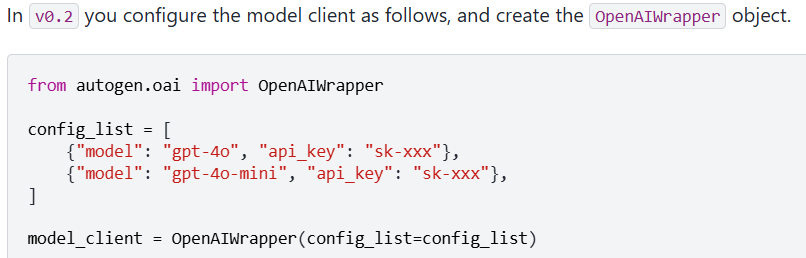

In `v0.4`, we offer two ways to create a model client:
## Component config

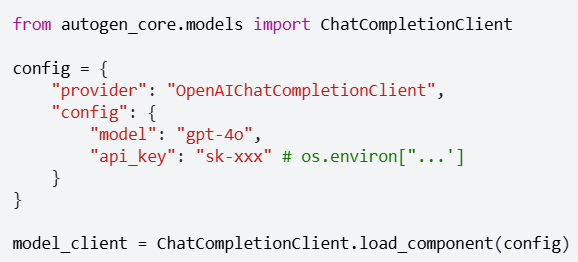

## Use model client class directly

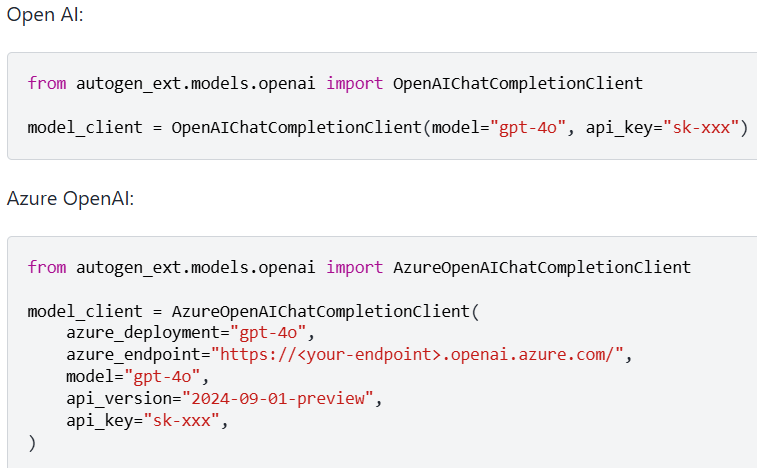

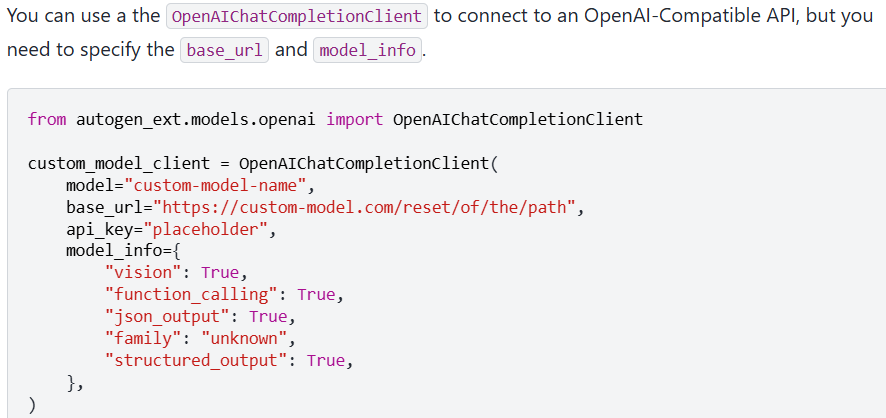

# Model Client Cache

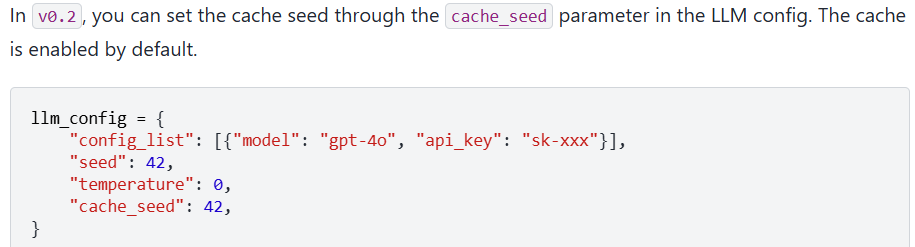

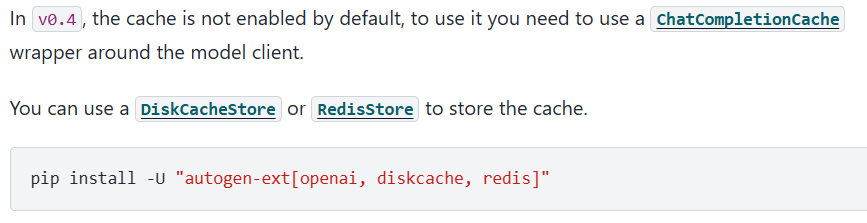

In [ ]:
import asyncio
import tempfile

from autogen_core.models import UserMessage
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.models.cache import ChatCompletionCache, CHAT_CACHE_VALUE_TYPE
from autogen_ext.cache_store.diskcache import DiskCacheStore
from diskcache import Cache


async def main():
    with tempfile.TemporaryDirectory() as tmpdirname:
        # Initialize the original client
        openai_model_client = OpenAIChatCompletionClient(model="gpt-4o")

        # Then initialize the CacheStore, in this case with diskcache.Cache.
        # You can also use redis like:
        # from autogen_ext.cache_store.redis import RedisStore
        # import redis
        # redis_instance = redis.Redis()
        # cache_store = RedisCacheStore[CHAT_CACHE_VALUE_TYPE](redis_instance)
        cache_store = DiskCacheStore[CHAT_CACHE_VALUE_TYPE](Cache(tmpdirname))
        cache_client = ChatCompletionCache(openai_model_client, cache_store)

        response = await cache_client.create([UserMessage(content="Hello, how are you?", source="user")])
        print(response)  # Should print response from OpenAI
        response = await cache_client.create([UserMessage(content="Hello, how are you?", source="user")])
        print(response)  # Should print cached response
        await openai_model_client.close()


asyncio.run(main())


# Assistant Agent

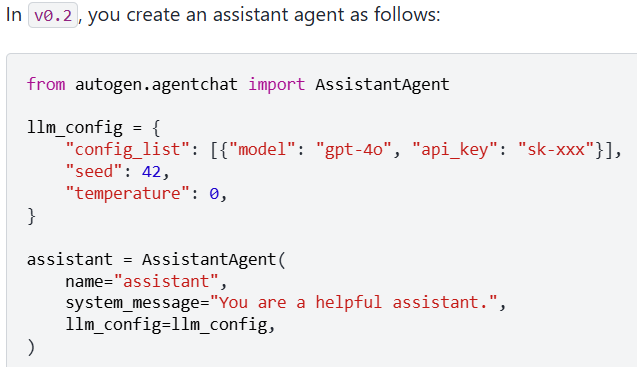

In `v0.4`, it is similar, but you need to specify `model_client` instead of `llm_config`.

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient

model_client = OpenAIChatCompletionClient(
    model="gpt-4o", 
    api_key="sk-xxx", 
    seed=42, 
    temperature=0)

assistant = AssistantAgent(
    name="assistant",
    system_message="You are a helpful assistant.",
    model_client=model_client,
)

You call `assistant.on_messages` or `assistant.on_messages_stream` to handle incoming messages. Furthermore, the `on_messages` and `on_messages_stream` methods are **asynchronous**, and the latter returns an async generator to stream the inner thoughts of the agent.

In [ ]:
import asyncio
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient

async def main() -> None:
    model_client = OpenAIChatCompletionClient(model="gpt-4o", seed=42, temperature=0)

    assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant.",
        model_client=model_client,
    )

    cancellation_token = CancellationToken()
    response = await assistant.on_messages([TextMessage(content="Hello!", source="user")], cancellation_token)
    print(response)

    await model_client.close()

asyncio.run(main())


The `CancellationToken` can be used to cancel the request asynchronously when you call `cancellation_token.cancel()`, which will cause the `await` on the `on_messages` call to raise a `CancelledError`.

# Multi-Modal Agent

The **AssistantAgent** in `v0.4` supports multi-modal inputs if the model client supports it.

In [ ]:
import asyncio
from pathlib import Path
from autogen_agentchat.messages import MultiModalMessage
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken, Image
from autogen_ext.models.openai import OpenAIChatCompletionClient

async def main() -> None:
    model_client = OpenAIChatCompletionClient(model="gpt-4o", seed=42, temperature=0)

    assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant.",
        model_client=model_client,
    )

    cancellation_token = CancellationToken()
    message = MultiModalMessage(
        content=["Here is an image:", Image.from_file(Path("test.png"))],
        source="user",
    )
    response = await assistant.on_messages([message], cancellation_token)
    print(response)

    await model_client.close()

asyncio.run(main())


# User Proxy

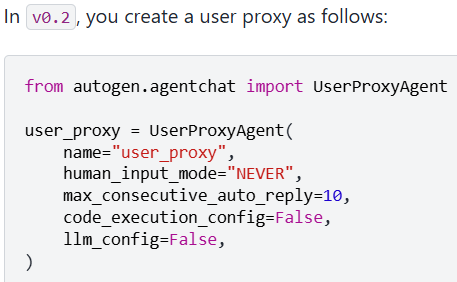

This user proxy would take input from the user through console, and would terminate if the incoming message ends with “TERMINATE”.

In `v0.4`, a user proxy is simply an agent that takes user input only, there is no other special configuration needed. 

In [1]:
from autogen_agentchat.agents import UserProxyAgent

user_proxy = UserProxyAgent("user_proxy")

# RAG Agent

- In `v0.4`, you can implement a RAG agent using the `Memory` class.
- This clear separation of concerns allows you to implement a memory store that uses any database or storage system you want (you have to inherit from the `Memory` class) and use it with an assistant agent. 
- Your application logic should determine how and when to add content to the memory store. For example, you may choose to call `memory.add` for every response from the assistant agent or use a separate LLM call to determine if the content should be added to the memory store. 

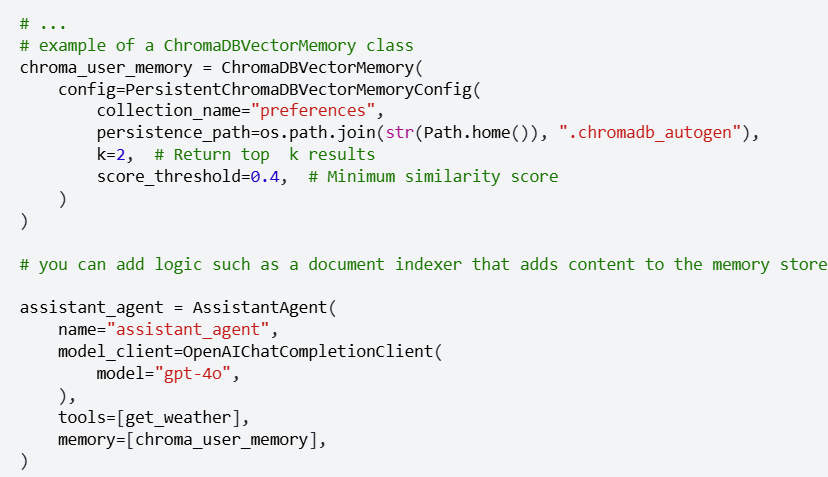

# Save and Load Agent State

In `v0.4`, you can call `save_state` and `load_state` methods on agents to save and load their state.

In [ ]:
import asyncio
import json
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient

async def main() -> None:
    model_client = OpenAIChatCompletionClient(model="gpt-4o", seed=42, temperature=0)

    assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant.",
        model_client=model_client,
    )

    cancellation_token = CancellationToken()
    response = await assistant.on_messages([TextMessage(content="Hello!", source="user")], cancellation_token)
    print(response)

    # Save the state.
    state = await assistant.save_state()

    # (Optional) Write state to disk.
    with open("assistant_state.json", "w") as f:
        json.dump(state, f)

    # (Optional) Load it back from disk.
    with open("assistant_state.json", "r") as f:
        state = json.load(f)
        print(state) # Inspect the state, which contains the chat history.

    # Carry on the chat.
    response = await assistant.on_messages([TextMessage(content="Tell me a joke.", source="user")], cancellation_token)
    print(response)

    # Load the state, resulting the agent to revert to the previous state before the last message.
    await assistant.load_state(state)

    # Carry on the same chat again.
    response = await assistant.on_messages([TextMessage(content="Tell me a joke.", source="user")], cancellation_token)
    # Close the connection to the model client.
    await model_client.close()

asyncio.run(main())


You can also call `save_state` and `load_state` on any teams, such as `RoundRobinGroupChat` to save and load the state of the entire team.

# Two-Agent Chat

In `v0.2`, you can create a two-agent chat for code execution as follows:

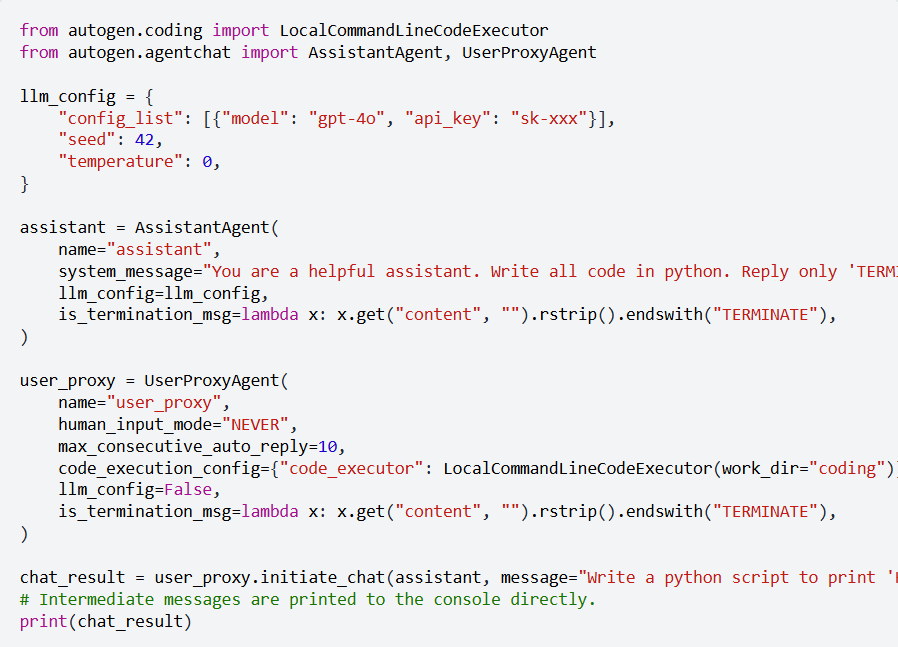

To get the same behavior in `v0.4`, you can use the `AssistantAgent` and `CodeExecutorAgent` together in a `RoundRobinGroupChat`.

In [ ]:
import asyncio
from autogen_agentchat.agents import AssistantAgent, CodeExecutorAgent
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.conditions import TextMentionTermination, MaxMessageTermination
from autogen_agentchat.ui import Console
from autogen_ext.code_executors.local import LocalCommandLineCodeExecutor
from autogen_ext.models.openai import OpenAIChatCompletionClient

async def main() -> None:
    model_client = OpenAIChatCompletionClient(model="gpt-4o", seed=42, temperature=0)

    assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant. Write all code in python. Reply only 'TERMINATE' if the task is done.",
        model_client=model_client,
    )

    code_executor = CodeExecutorAgent(
        name="code_executor",
        code_executor=LocalCommandLineCodeExecutor(work_dir="coding"),
    )

    # The termination condition is a combination of text termination and max message termination, either of which will cause the chat to terminate.
    termination = TextMentionTermination("TERMINATE") | MaxMessageTermination(10)

    # The group chat will alternate between the assistant and the code executor.
    group_chat = RoundRobinGroupChat([assistant, code_executor], termination_condition=termination)

    # `run_stream` returns an async generator to stream the intermediate messages.
    stream = group_chat.run_stream(task="Write a python script to print 'Hello, world!'")
    # `Console` is a simple UI to display the stream.
    await Console(stream)
    
    # Close the connection to the model client.
    await model_client.close()

asyncio.run(main())


# Tool Use

In `v0.4`, you really just need one agent – the **AssistantAgent** – to handle both the tool calling and tool execution.

In [ ]:
import asyncio
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage

def get_weather(city: str) -> str: # Async tool is possible too.
    return f"The weather in {city} is 72 degree and sunny."

async def main() -> None:
    model_client = OpenAIChatCompletionClient(model="gpt-4o", seed=42, temperature=0)
    assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant. You can call tools to help user.",
        model_client=model_client,
        tools=[get_weather],
        reflect_on_tool_use=True, # Set to True to have the model reflect on the tool use, set to False to return the tool call result directly.
    )
    while True:
        user_input = input("User: ")
        if user_input == "exit":
            break
        response = await assistant.on_messages([TextMessage(content=user_input, source="user")], CancellationToken())
        print("Assistant:", response.chat_message.to_text())
    await model_client.close()

asyncio.run(main())


When using tool-equipped agents inside a group chat such as **RoundRobinGroupChat**, you simply do the same as above to add tools to the agents, and create a group chat with the agents.

# Chat Result

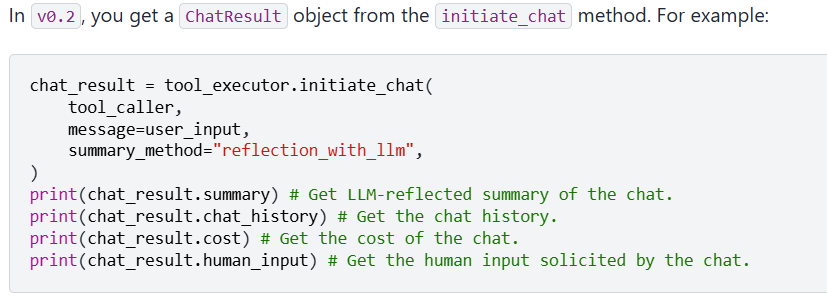

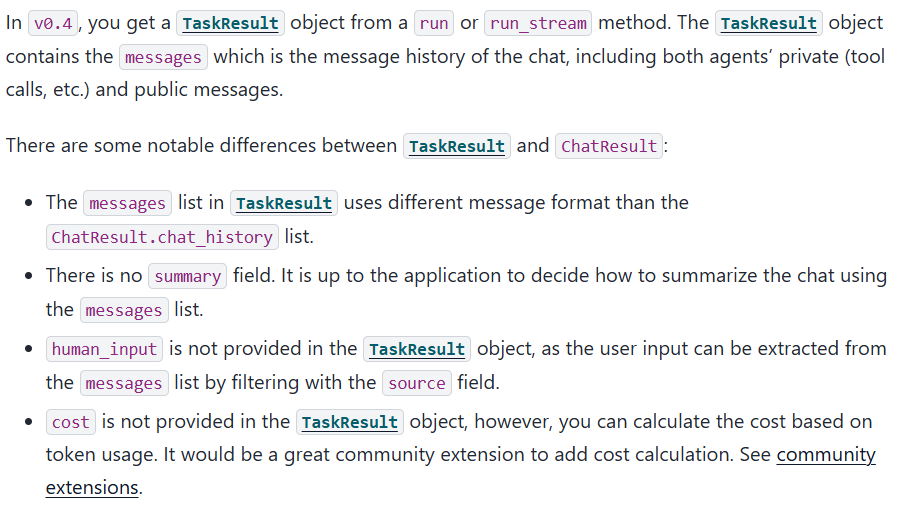

# Group Chat

In `v0.2`, you need to create a `GroupChat` class and pass it into a `GroupChatManager`, and have a participant that is a user proxy to initiate the chat. 

In `v0.4`, you can use the **RoundRobinGroupChat**

In [ ]:
import asyncio
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

async def main() -> None:
    model_client = OpenAIChatCompletionClient(model="gpt-4o", seed=42, temperature=0)

    writer = AssistantAgent(
        name="writer",
        description="A writer.",
        system_message="You are a writer.",
        model_client=model_client,
    )

    critic = AssistantAgent(
        name="critic",
        description="A critic.",
        system_message="You are a critic, provide feedback on the writing. Reply only 'APPROVE' if the task is done.",
        model_client=model_client,
    )

    # The termination condition is a text termination, which will cause the chat to terminate when the text "APPROVE" is received.
    termination = TextMentionTermination("APPROVE")

    # The group chat will alternate between the writer and the critic.
    group_chat = RoundRobinGroupChat([writer, critic], termination_condition=termination, max_turns=12)

    # `run_stream` returns an async generator to stream the intermediate messages.
    stream = group_chat.run_stream(task="Write a short story about a robot that discovers it has feelings.")
    # `Console` is a simple UI to display the stream.
    await Console(stream)
    # Close the connection to the model client.
    await model_client.close()

asyncio.run(main())


For LLM-based speaker selection, you can use the `SelectorGroupChat` instead.

# Group Chat with Custom Selector (Stateflow)

In `v0.2` group chat, when the `speaker_selection_method` is set to a custom function, it can override the default selection method. 

In `v0.4`, you can use the `SelectorGroupChat` with `selector_func` to achieve the same behavior. The `selector_func` is a function that takes the current message thread of the group chat and returns the next speaker’s name. If `None` is returned, the LLM-based selection method will be used.

In [ ]:
import asyncio
from typing import Sequence
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.messages import BaseAgentEvent, BaseChatMessage
from autogen_agentchat.teams import SelectorGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Note: This example uses mock tools instead of real APIs for demonstration purposes
def search_web_tool(query: str) -> str:
    if "2006-2007" in query:
        return """Here are the total points scored by Miami Heat players in the 2006-2007 season:
        Udonis Haslem: 844 points
        Dwayne Wade: 1397 points
        James Posey: 550 points
        ...
        """
    elif "2007-2008" in query:
        return "The number of total rebounds for Dwayne Wade in the Miami Heat season 2007-2008 is 214."
    elif "2008-2009" in query:
        return "The number of total rebounds for Dwayne Wade in the Miami Heat season 2008-2009 is 398."
    return "No data found."


def percentage_change_tool(start: float, end: float) -> float:
    return ((end - start) / start) * 100

def create_team(model_client : OpenAIChatCompletionClient) -> SelectorGroupChat:
    planning_agent = AssistantAgent(
        "PlanningAgent",
        description="An agent for planning tasks, this agent should be the first to engage when given a new task.",
        model_client=model_client,
        system_message="""
        You are a planning agent.
        Your job is to break down complex tasks into smaller, manageable subtasks.
        Your team members are:
            Web search agent: Searches for information
            Data analyst: Performs calculations

        You only plan and delegate tasks - you do not execute them yourself.

        When assigning tasks, use this format:
        1. <agent> : <task>

        After all tasks are complete, summarize the findings and end with "TERMINATE".
        """,
    )

    web_search_agent = AssistantAgent(
        "WebSearchAgent",
        description="A web search agent.",
        tools=[search_web_tool],
        model_client=model_client,
        system_message="""
        You are a web search agent.
        Your only tool is search_tool - use it to find information.
        You make only one search call at a time.
        Once you have the results, you never do calculations based on them.
        """,
    )

    data_analyst_agent = AssistantAgent(
        "DataAnalystAgent",
        description="A data analyst agent. Useful for performing calculations.",
        model_client=model_client,
        tools=[percentage_change_tool],
        system_message="""
        You are a data analyst.
        Given the tasks you have been assigned, you should analyze the data and provide results using the tools provided.
        """,
    )

    # The termination condition is a combination of text mention termination and max message termination.
    text_mention_termination = TextMentionTermination("TERMINATE")
    max_messages_termination = MaxMessageTermination(max_messages=25)
    termination = text_mention_termination | max_messages_termination

    # The selector function is a function that takes the current message thread of the group chat
    # and returns the next speaker's name. If None is returned, the LLM-based selection method will be used.
    def selector_func(messages: Sequence[BaseAgentEvent | BaseChatMessage]) -> str | None:
        if messages[-1].source != planning_agent.name:
            return planning_agent.name # Always return to the planning agent after the other agents have spoken.
        return None

    team = SelectorGroupChat(
        [planning_agent, web_search_agent, data_analyst_agent],
        model_client=OpenAIChatCompletionClient(model="gpt-4o-mini"), # Use a smaller model for the selector.
        termination_condition=termination,
        selector_func=selector_func,
    )
    return team

async def main() -> None:
    model_client = OpenAIChatCompletionClient(model="gpt-4o")
    team = create_team(model_client)
    task = "Who was the Miami Heat player with the highest points in the 2006-2007 season, and what was the percentage change in his total rebounds between the 2007-2008 and 2008-2009 seasons?"
    await Console(team.run_stream(task=task))

asyncio.run(main())


# Long Context Handling

In `v0.4`, we introduce the `ChatCompletionContext` base class that manages message history and provides a virtual view of the history. Applications can use built-in implementations such as `BufferedChatCompletionContext` to limit the message history sent to the model, or provide their own implementations that creates different virtual views.

In [ ]:
import asyncio
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from autogen_core.model_context import BufferedChatCompletionContext
from autogen_ext.models.openai import OpenAIChatCompletionClient

async def main() -> None:
    model_client = OpenAIChatCompletionClient(model="gpt-4o", seed=42, temperature=0)

    assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant.",
        model_client=model_client,
        model_context=BufferedChatCompletionContext(buffer_size=10), # Model can only view the last 10 messages.
    )
    while True:
        user_input = input("User: ")
        if user_input == "exit":
            break
        response = await assistant.on_messages([TextMessage(content=user_input, source="user")], CancellationToken())
        print("Assistant:", response.chat_message.to_text())
    
    await model_client.close()

asyncio.run(main())


# Observability and Control

- In `v0.4` `AgentChat`, you can observe the agents by using the `on_messages_stream` method which returns an async generator to stream the "inner thoughts" and actions of the agent.
- For teams, you can use the `run_stream` method to stream the inner conversation among the agents in the team. Your application can use these streams to observe the agents and teams in real-time.
- Both the `on_messages_stream` and `run_stream` methods takes a `CancellationToken` as a parameter which can be used to cancel the output stream asynchronously and stop the agent or team.
- `v0.4` API simply uses Python's `logging` module to log events such as model client calls.